

In this problem, we investigate how this programmatic interface can be used to solve a highly nonlinear problem.
Consider the shallow arch shown below (Clarke and Hancock, 1990):

![Shallow arch](./img/ClarkeHancock.png)

This problem exhibits several critical points along the solution path,
and requires the use of a sophisticated algorithm to properly traverse these.
In this study, we will investigate how the OpenSees framework can be used to compose these algorithms.

We will perform the analysis by creating an OpenSees `Model` data structure, and using
its *methods* to perform various tasks. A method is simply a function that
is linked to a particular instance of a data structure. In this case, the `Model`
data structure holds the geometry and state (i.e., the current values of solution variables) of our structural model. Some methods that you might see being used in this notebook include (you wont need to make any changes to the use of any of these):

- `Model.integrator(...)` This method configures the iteration strategy to be performed
  in the next increment
- `Model.analyze(n)` This method applies `n` increments, and between each increment, performs Newton-Raphson iterations.

In this notebook, the `Model` data structure is created by the `arch_model` helper function, which we load from the file [`arch.py`](./arch.py):

In [1]:
from arch import arch_model

We'll also find the following imports convenient:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import scienceplots
    plt.style.use(["steel"]) #(["ieee", "science", "notebook"])
except:
    pass

## Solution Strategy

Our general strategy is implemented in the following function `solve()`.
This function adopts an incremental approach
where the load is applied in small steps of varying size. 
The arguments to the function are:

- `model`: an OpenSees `Model` object
- `node` : an integer indicating which node to collect results from.

Both of these arguments will be supplied by the `arch_model` helper function mentioned
above.


In [3]:
def analyze(model, mid, increment, steps, dx, *args):
    # Initialize some variables
    xy = []      # Container to hold solution history (i.e., load factor and displacement at `node`)
    status = 0   # Convergence flag; Model.analyze() will return 0 if successful.

    # Configure the first load increment strategy; explained below
    increment(model, dx, *args)

    for step in range(steps):

        # 1. Perform Newton-Raphson iterations until convergence for 1 load
        #    increment
        status = model.analyze(1)

        # 2. Store the displacement and load factor
        xy.append([model.nodeDisp(mid, 2), model.getTime()])

        # 3. If the iterations failed, try cutting
        #    the increment arc-length in half
        if status != 0:
            dx /= 2
            increment(model, dx, *args)

    return np.array(xy).T

The strategies used by Clarke and Hancock are:

<dl>
<dt>Solution 1</dt><dd>
Iterative strategy: Constant load (Section 3.1)
<br/>
Load incrementation strategy: Direct incrementation of the load parameter (Section 4.1.1)
</dd>
<dt>Solution 2</dt><dd>
Iterative strategy: Constant vertical displacement under the load, $u_{\mathrm{mid}}$ (Section 3.2)
<br/>
Load incrementation strategy: Incrementation of the displacement component $u_{\mathrm{mid}}$ (Section 4.1.2)
</dd>
<dt>Solution 3</dt><dd>
Iterative strategy: Constant arc-length (Section 3.3)
<br/>
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 4</dt><dd>
Iterative strategy: Minimum unbalanced displacement norm (Section 3.5)
<br/>
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 5</dt><dd>
Iterative strategy: Constant weighted response (Section 3.7, equation (39))
<br/>
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 6</dt><dd>
Iterative strategy: Minimum unbalanced force norm (Section 3.6)
<br/>
Load incrementation strategy: Using the current stiffness parameter (Section 4.2, equation (57))
</dd>
<dt>Solution 7</dt><dd>
Iterative strategy: Minimum unbalanced force norm (Section 3.6)
<br/>
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 8</dt><dd>
Iterative strategy: Constant arc-length (Section 3.3)
<br/>
Load incrementation strategy: Using the current stiffness parameter (Section 4.2, equation (57))
</dd>
</dl>

In [4]:
def solution0(model, dx):
    model.integrator("LoadControl", 400.0)


def solution1(model, dx):
    Jd = 5
    model.integrator("LoadControl", dx, Jd, -800., 800.)


def solution2(model,  dx, *args):
    Jd  = 5
    mid, dof = args
    model.integrator("DisplacementControl", mid, dof, dx, Jd)


def norm_control(model, dx, *args):
    Jd  = 15
    model.integrator("MinUnbalDispNorm",  dx, Jd, -10, 10, det=True)


def arc_control(model, dx, *args,  a=0):
    model.integrator("ArcLength", dx, a, det=True, exp=0.0, reference="point")


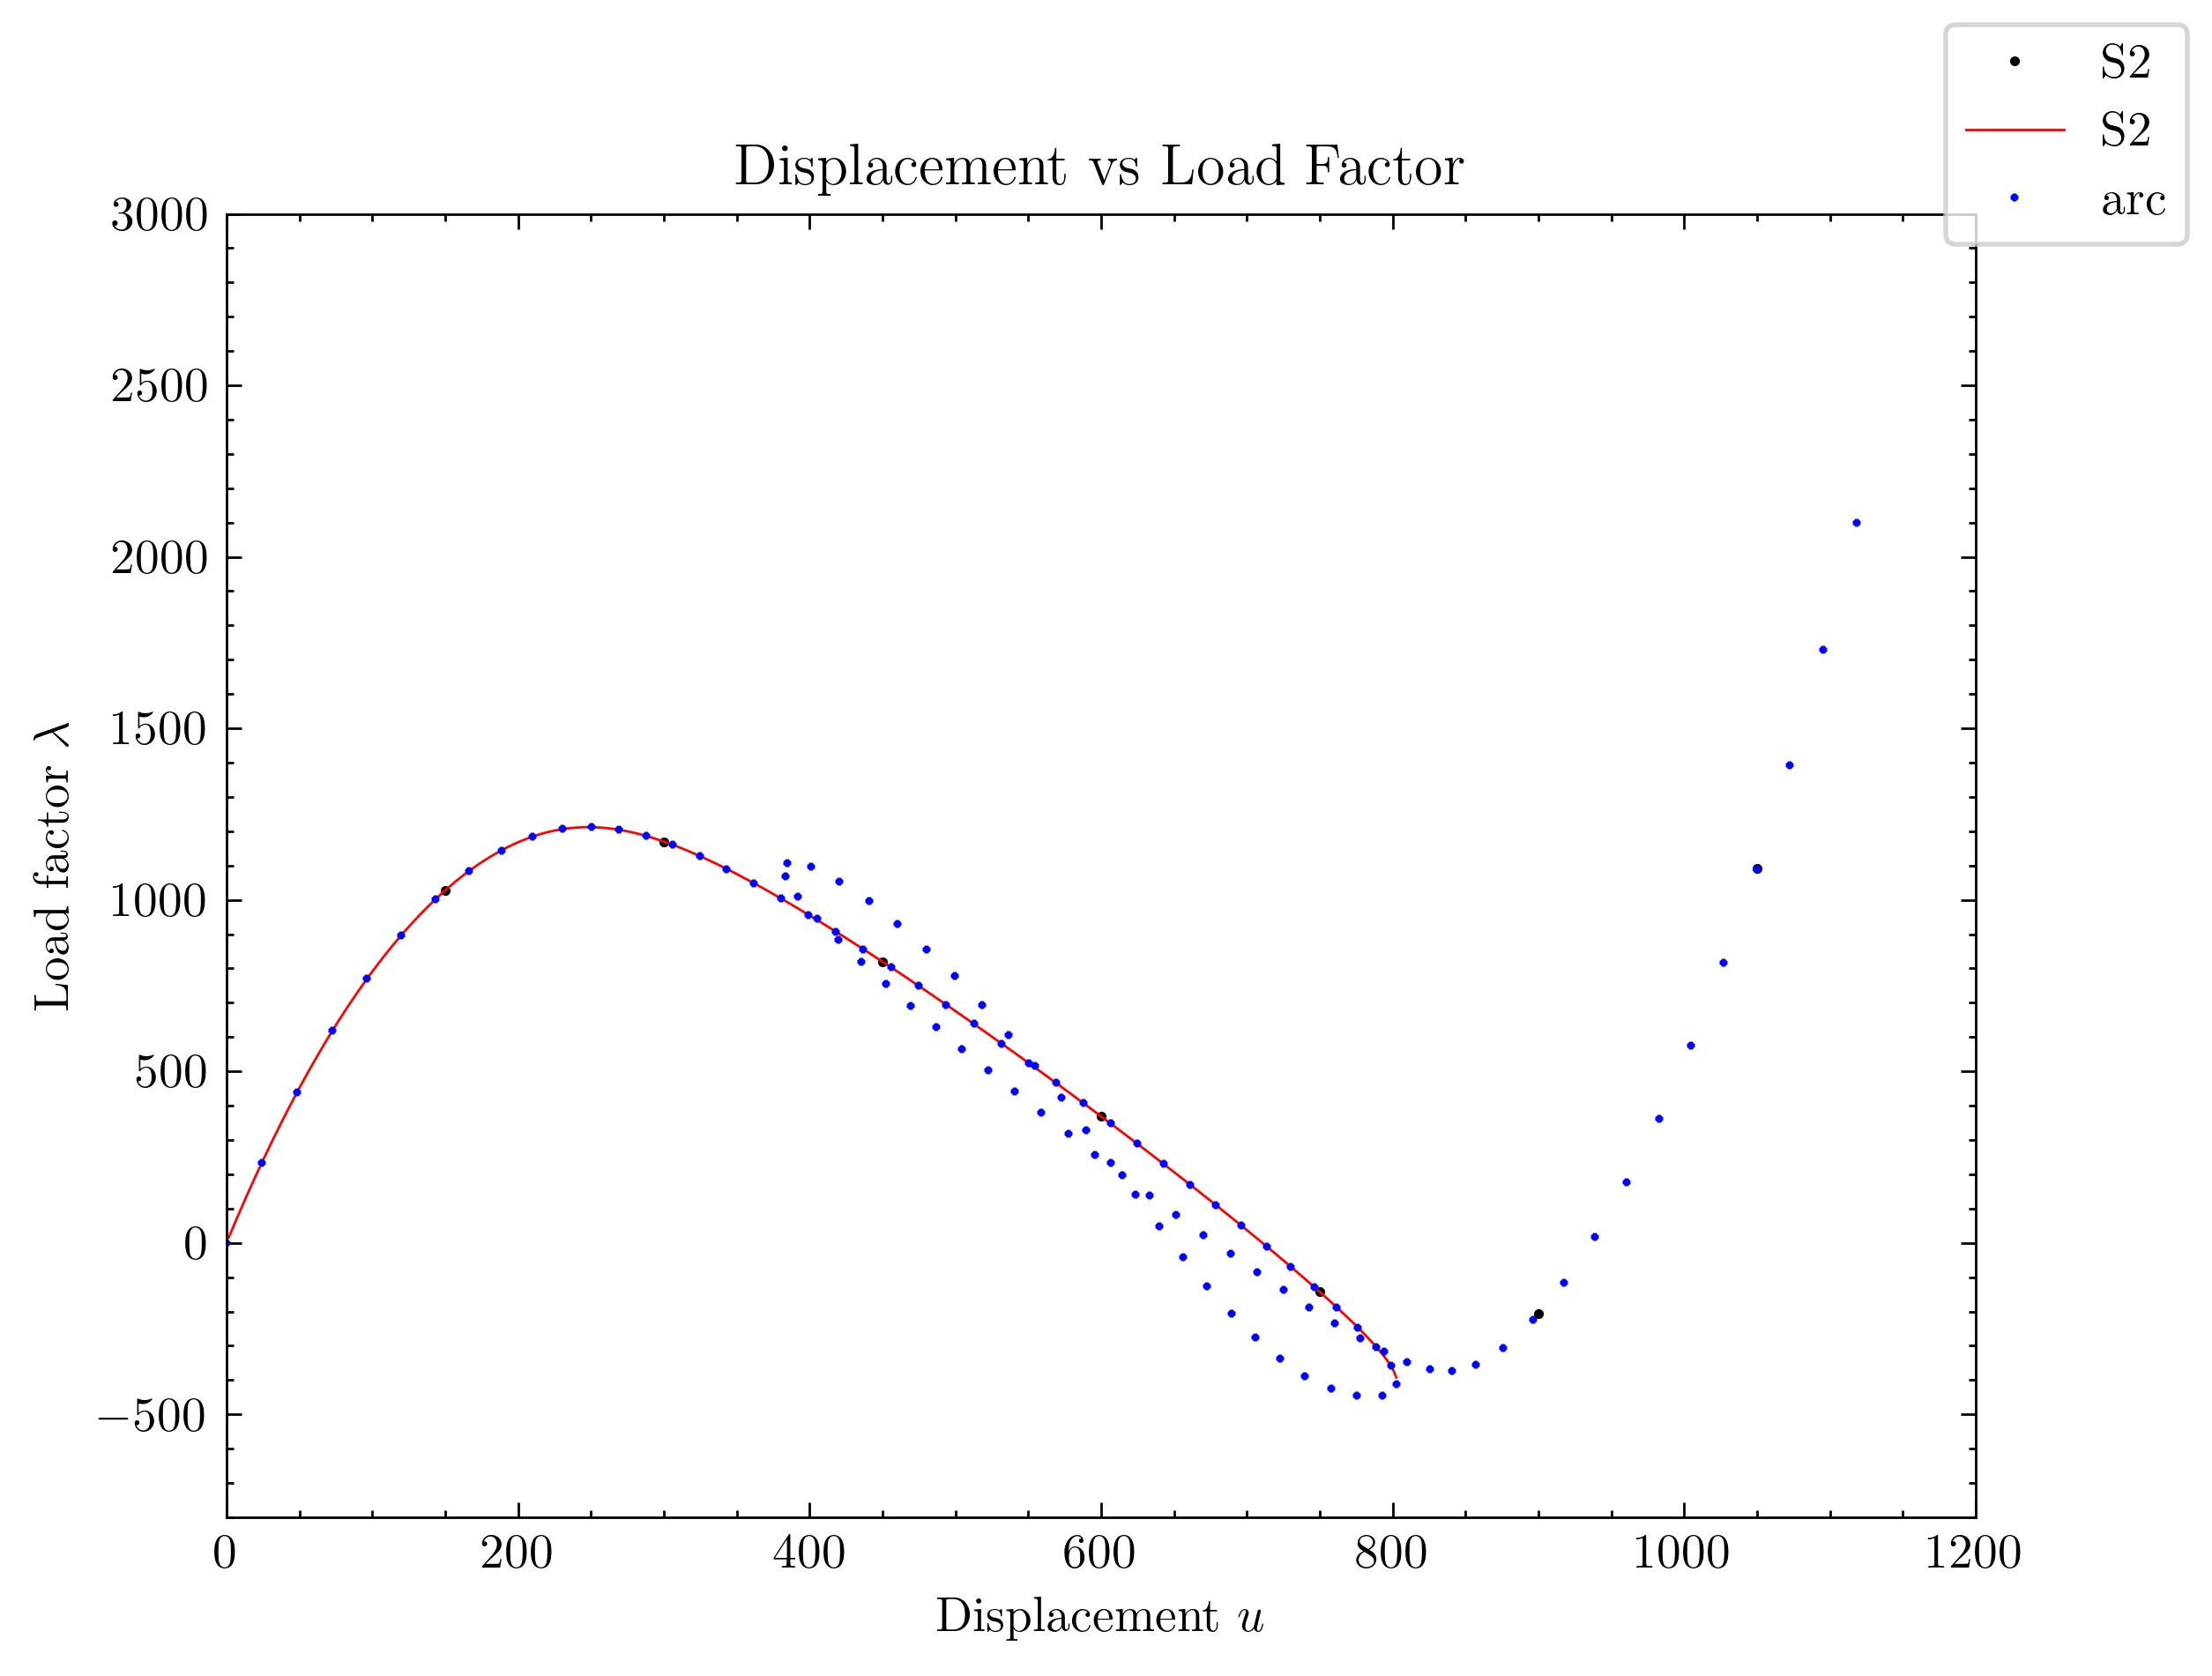

In [5]:
fig, ax = plt.subplots()

# x, y = solution0(*arch_model(), 6, 400.0)
# ax.plot(-x, y, 'x', label="S0")

# x, y = analyze(*arch_model(), solution1, 6, 400.0)
# ax.plot(-x, y, 'x', label="S1")
# print(y)

model, mid = arch_model()
x, y = analyze(model, mid, solution2,    7, -150, *(mid, 2))
ax.plot(-x, y, 'o', label="S2")

x, y = analyze(*arch_model(), solution2,  536, -1.5, *(mid, 2))
ax.plot(-x, y, '-', label="S2")

# x, y = analyze(*arch_model(), arc_control, 9500, 0.5, 0)
# ax.plot(-x, y, "-", label="arc")


x, y = analyze(*arch_model(), arc_control, 110,  45)
ax.plot(-x, y, "x", label="arc")

# x, y = analyze(*arch_model(), arc_control,  80,  88, 0)
# ax.plot(-x, y, "+", label="arc")

# x, y = analyze(*arch_model(), arc_control,  80, 188, 0)
# ax.plot(-x, y, "*", label="arc")

# x, y = analyze(*arch_model(), arc_control, 8000, 0.8, 0)
# ax.plot(-x, y, "x", label="arc")

# x, y = analyze(*arch_model(), norm_control,  7000, 1.0)
# ax.plot(-x, y, "-", label="norm")


ax.set_title("Displacement vs Load Factor")
ax.set_ylabel(r"Load factor $\lambda$")
ax.set_xlabel("Displacement $u$")

ax.set_xlim([0, 1200])
ax.set_ylim([-800, 3000])
fig.legend();

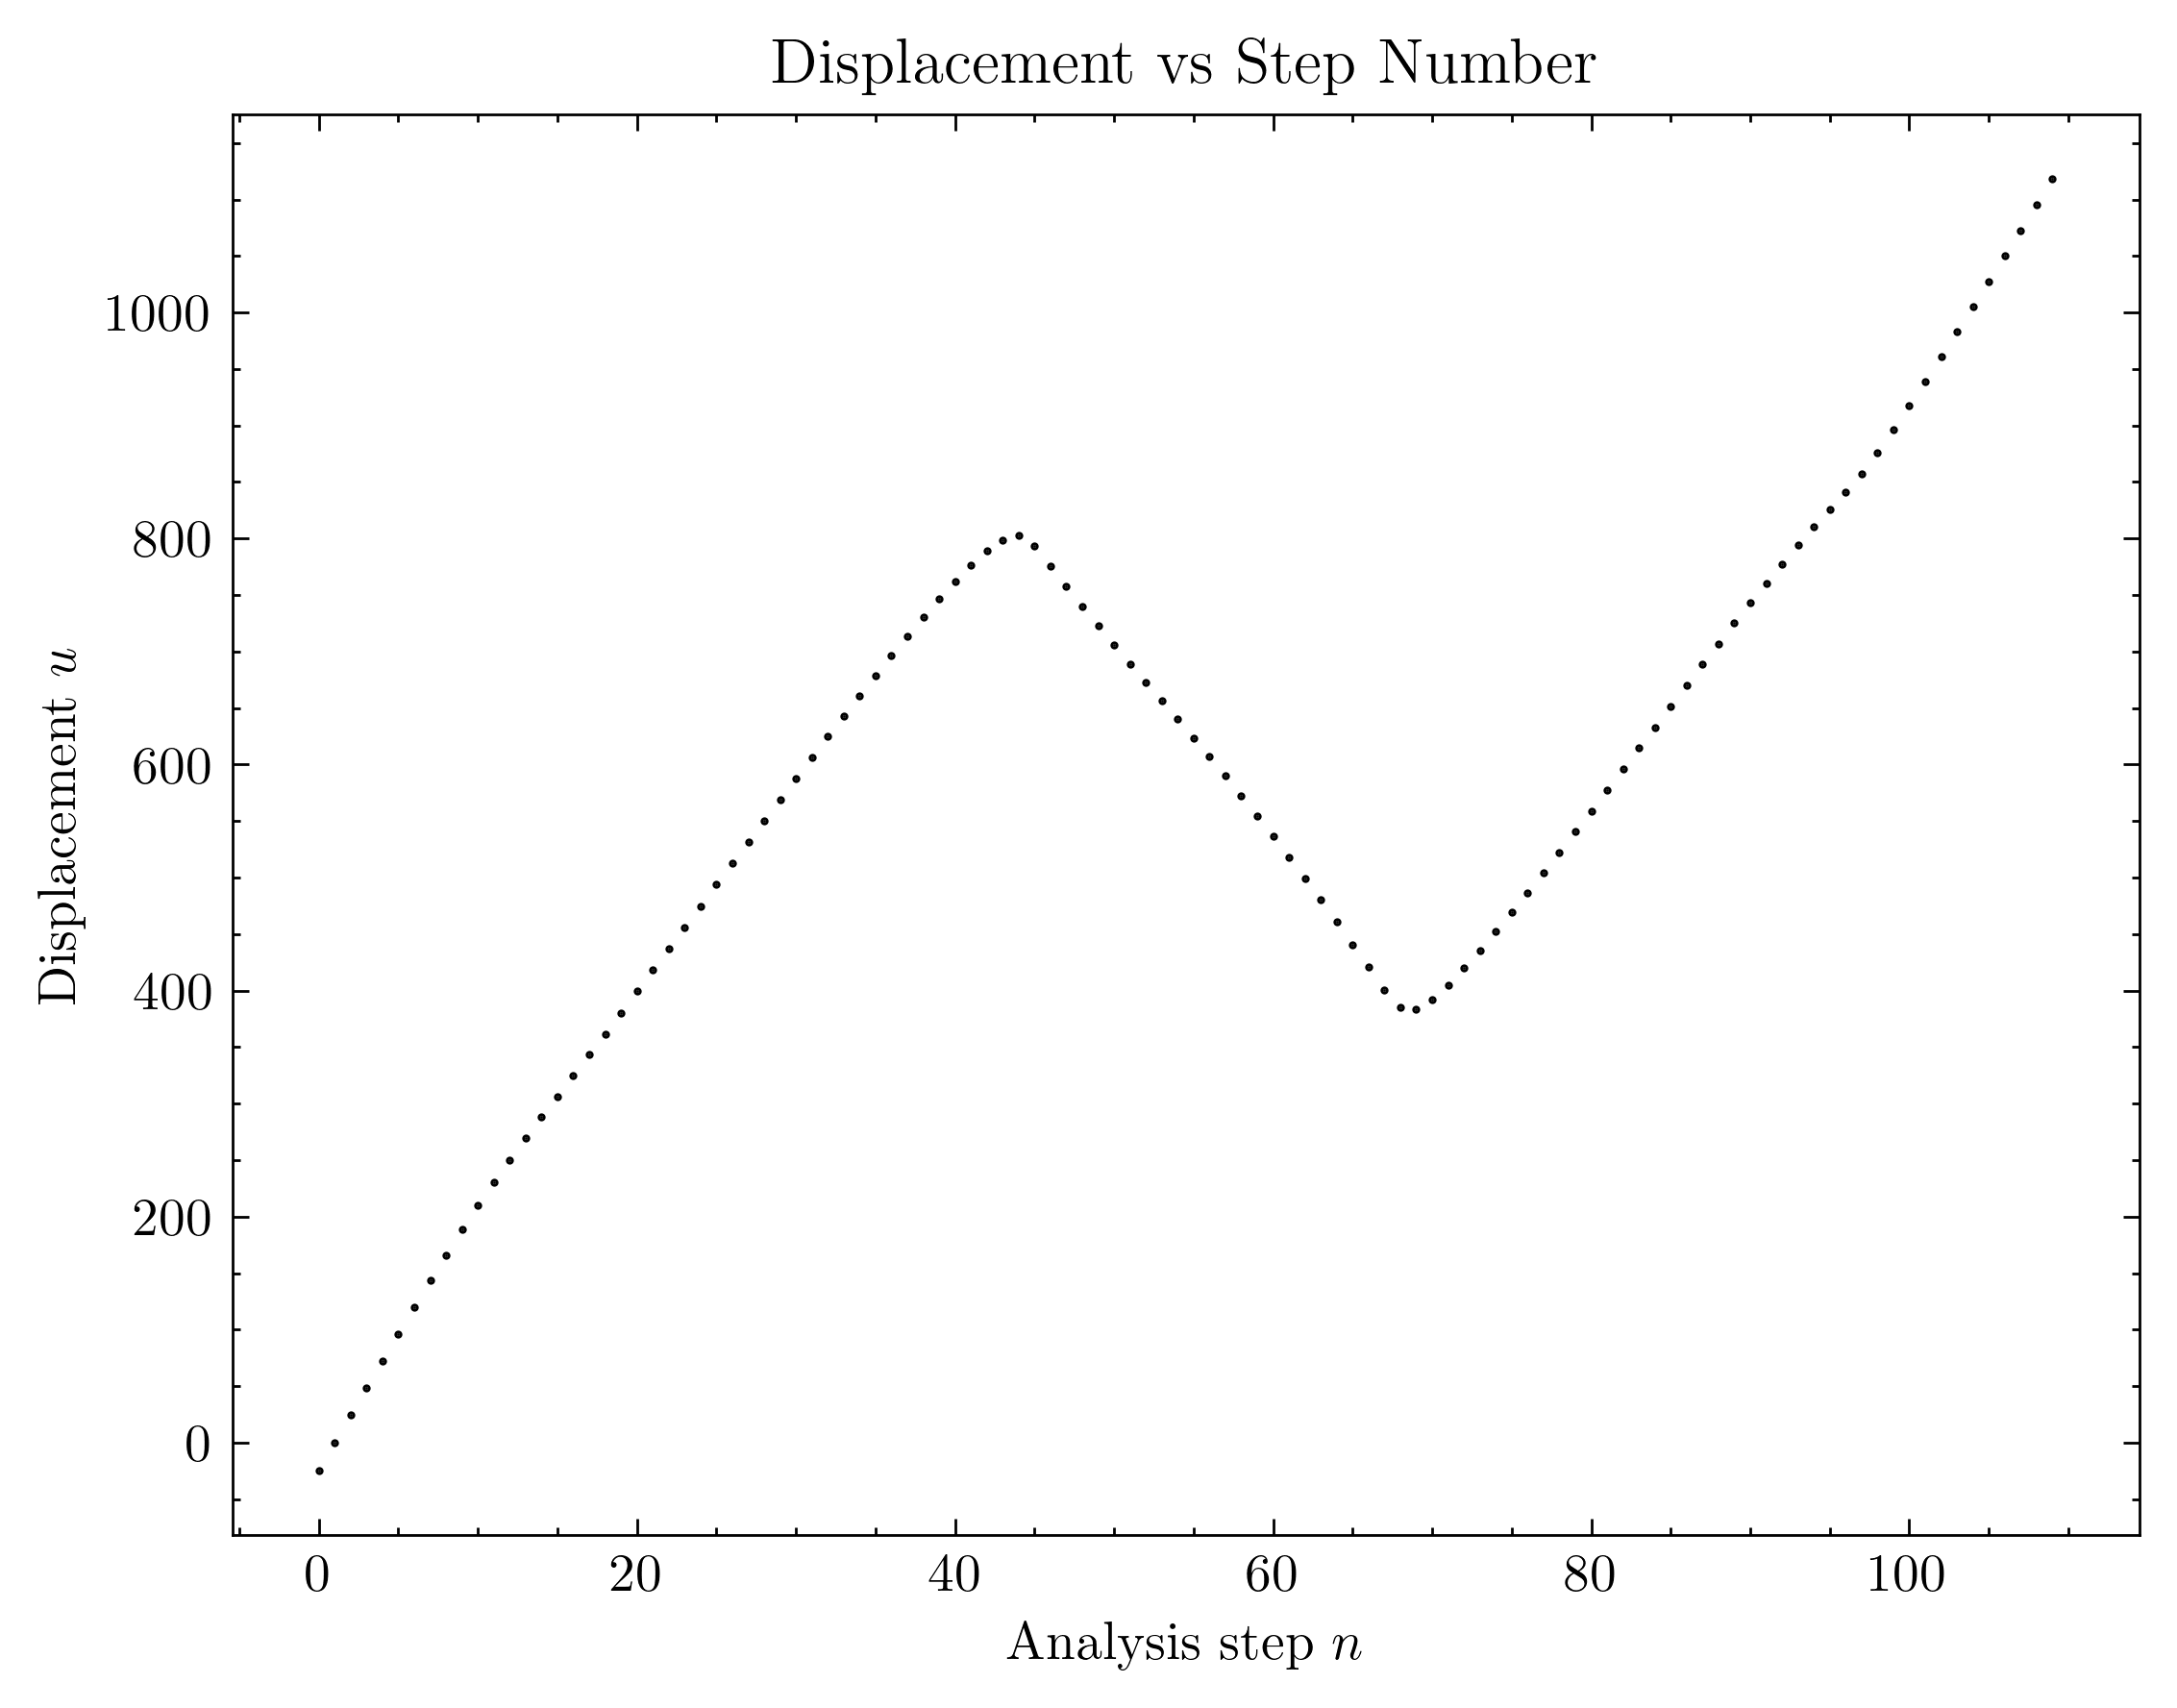

In [7]:
fix, ax = plt.subplots()
ax.plot(-x, '.');
ax.set_title("Displacement vs Step Number")
ax.set_ylabel("Displacement $u$")
ax.set_xlabel("Analysis step $n$");

The following animation of the solution is created in [`Animating.ipynb`](./Animating.ipynb)

<img src="arch.gif" width="80%">

## References


> Clarke, M.J. and Hancock, G.J. (1990) ‘A study of incremental‐iterative strategies for non‐linear analyses’, International Journal for Numerical Methods in Engineering, 29(7), pp. 1365–1391. Available at: https://doi.org/10.1002/nme.1620290702.
